In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Abrindo o dataset

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
data_path = "./dataset/cifar-10/"
save_model_path = './trained_models/cifar10/'

data = unpickle(data_path+'data_batch_1')

In [5]:
data.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [6]:
data[b'data'].shape

(10000, 3072)

In [7]:
def image_reshape(raw_image):
    
    red = raw_image[:1024]
    green = raw_image[1024:2048]
    blue = raw_image[2048:]
    
    return np.stack((red, green, blue), axis=-1).reshape((32,32,3))

In [8]:
image_reshape(data[b'data'][1]).shape

(32, 32, 3)

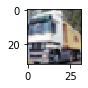

In [9]:
plt.figure(figsize = (1,1))
plt.imshow(image_reshape(data[b'data'][1]))

In [10]:
data[b'labels'][1]

9

In [11]:
data = unpickle(data_path+'data_batch_{}'.format(1))
img_train = data[b'data']
label_train = np.array(data[b'labels'])
for i in range(2,6):
    data = unpickle(data_path+'data_batch_{}'.format(i))
    img_train = np.concatenate((img_train, data[b'data']))
    label_train = np.concatenate((label_train, np.array(data[b'labels'])))
    
data = unpickle(data_path+'test_batch')
img_test = data[b'data']
label_test = np.array(data[b'labels'])

In [12]:
print('img_train shape: {}'.format(img_train.shape))
print('label_train shape: {}'.format(label_train.shape))
print('img_test shape: {}'.format(img_test.shape))
print('label_test shape: {}'.format(label_test.shape))

img_train shape: (50000, 3072)
label_train shape: (50000,)
img_test shape: (10000, 3072)
label_test shape: (10000,)


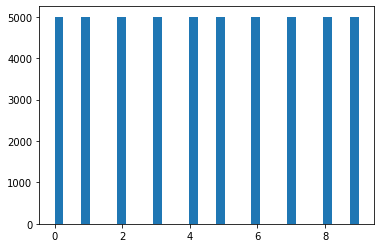

In [13]:
plt.hist(label_train, bins='auto')
plt.show()

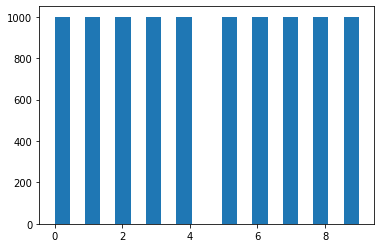

In [14]:
plt.hist(label_test, bins='auto')
plt.show()

In [15]:
img_train = np.apply_along_axis(image_reshape, 1, img_train)
img_test = np.apply_along_axis(image_reshape, 1, img_test)

In [16]:
img_train.shape

(50000, 32, 32, 3)

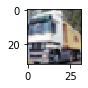

In [17]:
plt.figure(figsize = (1,1))
plt.imshow(img_train[1])

In [18]:
img_train = img_train/255
img_test = img_test/255

In [19]:
def mk_class_output_single_out(label_array):

    t = []
    for label in label_array:
        out = [0,0,0,0,0,0,0,0,0,0]
        out[int(label)]=1
        t.append(out)

    return np.array(t)

In [20]:
label_train = mk_class_output_single_out(label_train)
label_test = mk_class_output_single_out(label_test)

In [21]:
print('img_train shape: {}'.format(img_train.shape))
print('label_train shape: {}'.format(label_train.shape))
print('img_test shape: {}'.format(img_test.shape))
print('label_test shape: {}'.format(label_test.shape))

img_train shape: (50000, 32, 32, 3)
label_train shape: (50000, 10)
img_test shape: (10000, 32, 32, 3)
label_test shape: (10000, 10)


In [22]:
#img_train = img_train[:10000]
#label_train = label_train[:10000]
#img_test = img_test[:1000]
#label_test = label_test[:1000]

## Construindo o modelo

In [25]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.optimizers import Adam, RMSprop
#import tensorflow as tf

from tensorflow.keras.utils import plot_model

In [26]:
def My_ConvLSTM_Model(channels, pixels_x, pixels_y, num_categories):
    img_input  = Input(shape=(pixels_x, pixels_y, channels)
                    , name='img_input')

    first_Conv2D = Conv2D(filters=50, kernel_size=(3, 3)
                       , data_format='channels_last'
                       , activation='relu'
                       , padding='same')(img_input)
    first_Conv2D = BatchNormalization()(first_Conv2D)
    #first_Conv2D = MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_first')(first_Conv2D)

    second_Conv2D = Conv2D(filters=40, kernel_size=(3, 3)
                        , data_format='channels_last'
                        , activation='relu'
                        , padding='same')(first_Conv2D)
    second_Conv2D = BatchNormalization()(second_Conv2D)
    #second_Conv2D = MaxPooling2D(pool_size=(3, 3), padding='same', data_format='channels_first')(second_Conv2D)
    
    third_Conv2D = Conv2D(filters=30, kernel_size=(3, 3)
                        , data_format='channels_last'
                        , padding='same')(second_Conv2D)
    third_Conv2D = BatchNormalization()(third_Conv2D)
    
    fourth_Conv2D = Conv2D(filters=30, kernel_size=(3, 3)
                        , data_format='channels_last'
                        , padding='same')(third_Conv2D)
    
    flat_layer = Flatten()(fourth_Conv2D)

    first_Dense = Dense(256,)(flat_layer)
    second_Dense = Dense(128,)(first_Dense)

    target = Dense(num_categories, name='output')(second_Dense)
    

    seq = Model(inputs=img_input, outputs=target, name='Model')

    return seq

In [27]:
channels = 3
pixels_x = 32
pixels_y = 32
num_categories = 10

In [28]:
model = My_ConvLSTM_Model(channels, pixels_x, pixels_y, num_categories)

In [29]:
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
model.summary()

Model: "Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_input (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 50)        1400      
_________________________________________________________________
batch_normalization_v2 (Batc (None, 32, 32, 50)        200       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 40)        18040     
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 32, 32, 40)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 30)        10830     
_________________________________________________________________
batch_normalization_v2_2 (Ba (None, 32, 32, 30)        120   

In [30]:
plot_model(model, to_file=save_model_path+'model_architecture_all.png', show_shapes=True, show_layer_names=True)

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

## Treinando o modelo

In [28]:
print('img_train shape: {}'.format(img_train.shape))
print('label_train shape: {}'.format(label_train.shape))
print('img_test shape: {}'.format(img_test.shape))
print('label_test shape: {}'.format(label_test.shape))

img_train shape: (50000, 32, 32, 3)
label_train shape: (50000, 10)
img_test shape: (10000, 32, 32, 3)
label_test shape: (10000, 10)


In [29]:
mc = ModelCheckpoint(filepath=save_model_path+'weights.{epoch:02d}.hdf5', monitor = "val_loss", 
                     verbose = 0,save_best_only = False, save_weights_only = False, period = 3)

history = model.fit(
    x=img_train, y=label_train
    , batch_size=None
    , epochs=100
    , verbose=1
    , callbacks=[mc]
    , validation_data=(img_test, label_test)
    , shuffle=True
    , initial_epoch=0
    
    #, steps_per_epoch=300
    #, validation_steps=100
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 1208s 24ms/step - loss: 0.3518 - acc: 0.2792 - val_loss: 0.0993 - val_acc: 0.3656
Epoch 2/100
50000/50000 [==============================] - 1152s 23ms/step - loss: 0.0803 - acc: 0.4557 - val_loss: 0.0803 - val_acc: 0.4420
Epoch 3/100
50000/50000 [==============================] - 1152s 23ms/step - loss: 0.0717 - acc: 0.5186 - val_loss: 0.0737 - val_acc: 0.4825
Epoch 4/100
50000/50000 [==============================] - 1151s 23ms/step - loss: 0.0682 - acc: 0.5583 - val_loss: 0.0711 - val_acc: 0.5164
Epoch 5/100
50000/50000 [==============================] - 1158s 23ms/step - loss: 0.0653 - acc: 0.5889 - val_loss: 0.0689 - val_acc: 0.5366
Epoch 6/100
50000/50000 [==============================] - 1153s 23ms/step - loss: 0.0630 - acc: 0.6173 - val_loss: 0.0663 - val_acc: 0.5643
Epoch 7/100
50000/50000 [==============================] - 1149s 23ms/step - loss: 0.0609 - acc: 0.6453 

## Visualizando o treinamento

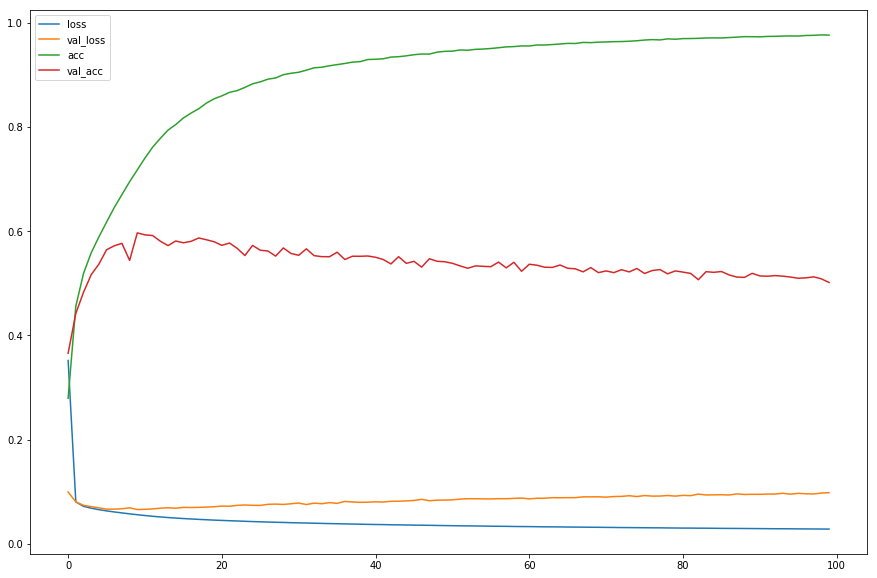

In [30]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')

plt.legend(loc='best')
plt.show()

In [31]:
import json

In [32]:
file_name = 'cifar10_cnn_single_out'
model.save(save_model_path+file_name+'.h5')

with open(save_model_path+file_name+'_History.json', 'w') as f:
    json.dump(history.history, f)

## Carregando o modelo

Para ver se acerta na classificação

In [33]:
from keras.models import load_model

def get_pred_value(prediction):
    return np.unravel_index(np.argmax(prediction, axis=None), prediction.shape)[1]

def get_target_value(prediction):
    return np.unravel_index(np.argmax(prediction, axis=None), prediction.shape)[0]

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def plota_estatisticas(id_test, model, label_test, img_test, categories):
    print('Label: {}'.format(categories[int(get_target_value(label_test[id_test]))]))
    prediction = model.predict(img_test[id_test:id_test+1])
    print('Prediction: {}'.format(categories[get_pred_value(prediction)]))
    plt.figure(figsize = (1,1))
    plt.imshow(img_test[id_test])
    plt.show()
    print('Softmax: ')
    for cat, percent in zip(categories, softmax(prediction[0])):
        print('{}: {:0.2f}%'.format(cat, percent*100))
        
        
def printa_previsao(id_test, model, label_test, img_test, categories):
    print('Label: {}'.format(categories[int(get_target_value(label_test[id_test]))]))
    prediction = model.predict(img_test[id_test:id_test+1])
    print('Prediction: {}'.format(categories[get_pred_value(prediction)]))
    
def plota_imagem(img_test, id_test):
    plt.figure(figsize = (1,1))
    plt.imshow(img_test[id_test])
    plt.show()
    
def printa_softmax(categories, prediction):
    print('Softmax: ')
    for cat, percent in zip(categories, softmax(prediction[0])):
        print('{}: {:0.2f}%'.format(cat, percent*100))
        
def plota_estatisticas_organizado(id_test, model, label_test, img_test, categories):
    printa_previsao(id_test, model, label_test, img_test, categories)
    plota_imagem(img_test, id_test)
    printa_softmax(categories, prediction)

In [34]:
model = load_model(save_model_path+'cifar10_cnn_single_out.h5')

In [35]:
categories = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [36]:
def porcentagem_acertos(model, label_list, img_list):
    num_acertos = 0
    for id_test in range(0,label_list.shape[0]):
        expected = categories[int(get_target_value(label_list[id_test]))]
        prediction = categories[get_pred_value(model.predict(img_list[id_test:id_test+1]))]
        num_acertos += expected==prediction

    print('Acertos: {} de {}: {:0.2f}%'.format(num_acertos, label_list.shape[0], num_acertos*100/label_list.shape[0]))

In [37]:
acc, loss = model.evaluate(img_train, label_train)
print('Train Set: Acc: {:0.2f}, Loss: {:0.2f}'.format(acc, loss))

50000/50000 [==============================] - 350s 7ms/step
Train Set: Acc: 0.03, Loss: 0.98


In [38]:
porcentagem_acertos(model, label_train, img_train)

Acertos: 49079 de 50000: 98.16%


In [39]:
acc, loss = model.evaluate(img_test, label_test)
print('Test Set: Acc: {:0.2f}, Loss: {:0.2f}'.format(acc, loss))

10000/10000 [==============================] - 70s 7ms/step
Test Set: Acc: 0.10, Loss: 0.50


In [40]:
porcentagem_acertos(model, label_test, img_test)

Acertos: 5015 de 10000: 50.15%


Label: ship
Prediction: bird


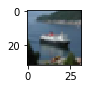

Softmax: 
airplane: 11.34%
automobile: 10.60%
bird: 13.36%
cat: 7.62%
deer: 10.92%
dog: 7.90%
frog: 8.96%
horse: 7.61%
ship: 10.49%
truck: 11.21%


In [41]:
plota_estatisticas(1059, model, label_test, img_test, categories)

Label: cat
Prediction: ship


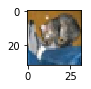

Softmax: 
airplane: 7.40%
automobile: 7.60%
bird: 12.44%
cat: 12.94%
deer: 9.54%
dog: 9.08%
frog: 7.98%
horse: 6.30%
ship: 14.36%
truck: 12.37%


In [42]:
plota_estatisticas(0, model, label_test, img_test, categories)

Label: deer
Prediction: deer


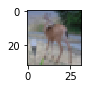

Softmax: 
airplane: 8.03%
automobile: 8.67%
bird: 13.04%
cat: 8.35%
deer: 15.90%
dog: 7.15%
frog: 11.94%
horse: 10.07%
ship: 10.02%
truck: 6.83%


In [43]:
plota_estatisticas(100, model, label_test, img_test, categories)

Label: horse
Prediction: cat


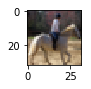

Softmax: 
airplane: 7.64%
automobile: 11.70%
bird: 10.45%
cat: 16.82%
deer: 7.59%
dog: 11.20%
frog: 7.16%
horse: 11.07%
ship: 6.39%
truck: 9.97%


In [44]:
plota_estatisticas(435, model, label_test, img_test, categories)